C:\Users\User\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\User/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:08<00:00, 3.73MB/s]
Validating Epoch 1/10: 100%|██████████| 9/9 [00:57<00:00,  6.42s/it]


Epoch 1 - Train Loss: 2.3421, Val Loss: 1.9416, Train Acc: 0.2192, Val Acc: 0.3269


Validating Epoch 2/10: 100%|██████████| 9/9 [00:24<00:00,  2.74s/it]


Epoch 2 - Train Loss: 1.8067, Val Loss: 1.6880, Train Acc: 0.4038, Val Acc: 0.3615


Validating Epoch 3/10: 100%|██████████| 9/9 [00:23<00:00,  2.67s/it]


Epoch 3 - Train Loss: 1.5257, Val Loss: 1.5079, Train Acc: 0.4760, Val Acc: 0.4269


Validating Epoch 4/10: 100%|██████████| 9/9 [00:55<00:00,  6.20s/it]


Epoch 4 - Train Loss: 1.3159, Val Loss: 1.4066, Train Acc: 0.5327, Val Acc: 0.4462


Validating Epoch 5/10: 100%|██████████| 9/9 [00:24<00:00,  2.70s/it]


Epoch 5 - Train Loss: 1.1599, Val Loss: 1.3548, Train Acc: 0.5779, Val Acc: 0.4577


Validating Epoch 6/10: 100%|██████████| 9/9 [01:35<00:00, 10.61s/it]


Epoch 6 - Train Loss: 1.0242, Val Loss: 1.3180, Train Acc: 0.6202, Val Acc: 0.4500


Validating Epoch 7/10: 100%|██████████| 9/9 [01:22<00:00,  9.20s/it]


Epoch 7 - Train Loss: 0.9201, Val Loss: 1.3504, Train Acc: 0.6510, Val Acc: 0.4346


Validating Epoch 8/10: 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]


Epoch 8 - Train Loss: 0.8951, Val Loss: 1.3531, Train Acc: 0.6404, Val Acc: 0.4462


Validating Epoch 9/10: 100%|██████████| 9/9 [00:26<00:00,  2.96s/it]


Epoch 9 - Train Loss: 0.8073, Val Loss: 1.2421, Train Acc: 0.6663, Val Acc: 0.4577


Validating Epoch 10/10: 100%|██████████| 9/9 [00:25<00:00,  2.82s/it]


Epoch 10 - Train Loss: 0.7903, Val Loss: 1.2993, Train Acc: 0.6788, Val Acc: 0.5038


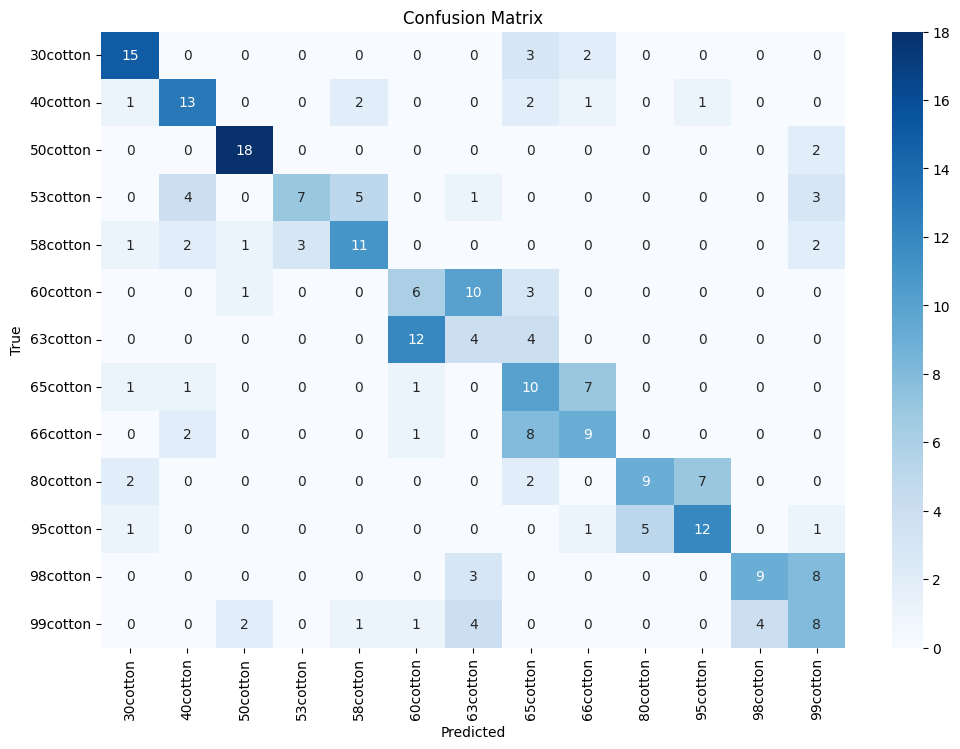

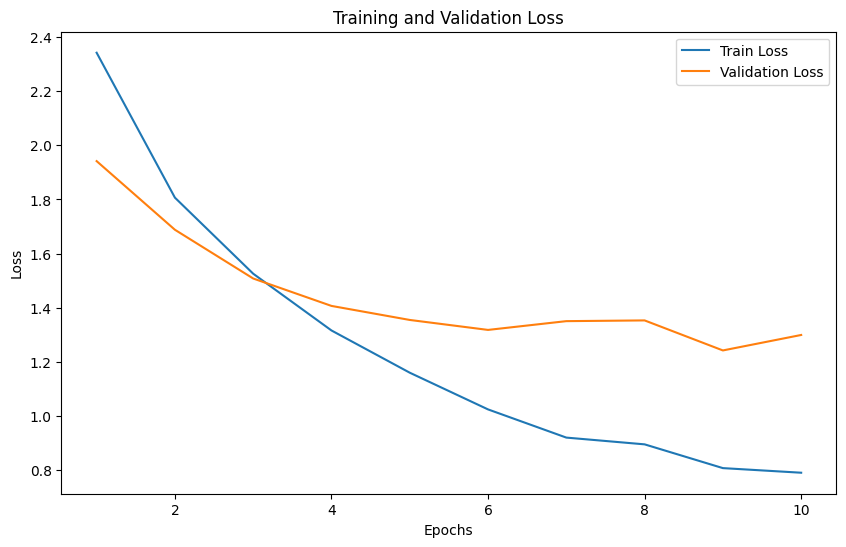

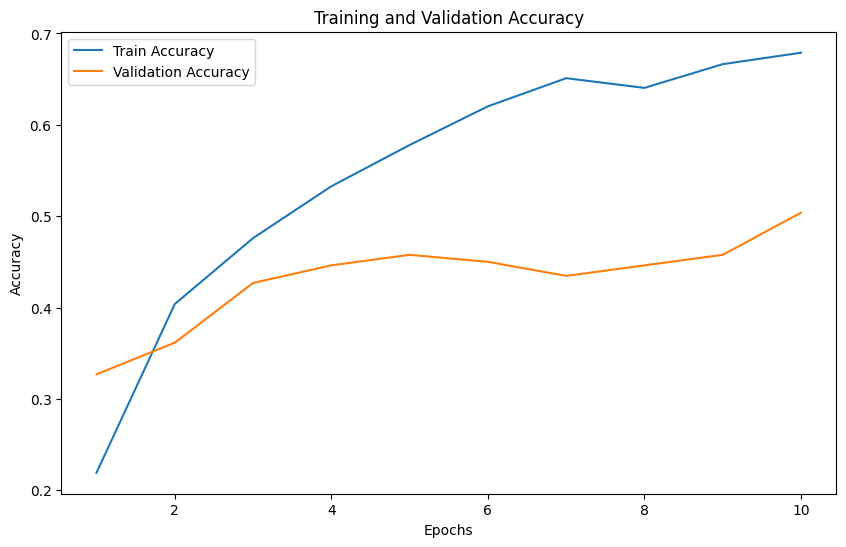

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

# Dataset class
class CottonDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(root_dir))

        for label, class_name in enumerate(self.class_names):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):
                    self.image_paths.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return self.__getitem__((idx + 1) % len(self))

        if self.transform:
            image = self.transform(image)

        return image, label

# Define augmentation transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Dataset path
data_dir = r"C:\Users\User\Downloads\Original\Original"

# Split data into train and validation sets
all_image_paths = []
all_labels = []
class_names = sorted(os.listdir(data_dir))

for label, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        if os.path.isfile(img_path):
            all_image_paths.append(img_path)
            all_labels.append(label)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

class SplitCottonDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return self.__getitem__((idx + 1) % len(self))

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = SplitCottonDataset(train_paths, train_labels, transform=train_transform)
val_dataset = SplitCottonDataset(val_paths, val_labels, transform=val_transform)

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Load DenseNet121 Model
model = models.densenet121(pretrained=True)

# Modify the classifier to match the number of classes
model.classifier = nn.Linear(model.classifier.in_features, len(class_names))

# Device and hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training and Evaluation Function
def train_model_with_plots(model, train_loader, val_loader, criterion, optimizer, epochs=10, save_dir="./saved_models"):
    os.makedirs(save_dir, exist_ok=True)

    # Metrics storage
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        all_labels, all_preds = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}/{epochs}"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct / total)

        # Save the model
        torch.save(model.state_dict(), os.path.join(save_dir, f"densenet121_epoch_{epoch+1}.pth"))
        print(f"Epoch {epoch+1} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    # Final confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, epochs+1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.show()

# Start training
train_model_with_plots(model, train_loader, val_loader, criterion, optimizer, epochs=10, save_dir=r"C:\Users\User\Downloads\Original")
